In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
data_dir = '/content/drive/MyDrive/'

In [3]:
import numpy as np
import torch
import torch, torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset,DataLoader
import sys
import logging
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

jacobians = np.load(data_dir + 'jacobians_boxing.p', allow_pickle=True)
values = np.load(data_dir +'values_boxing.p', allow_pickle=True)

test_jacobians = np.load(data_dir + 'jacobians_boxing_test.p', allow_pickle=True)
test_values = np.load(data_dir +'values_boxing_test.p', allow_pickle=True)

In [4]:
jacobians[1].shape
# test_jacobians[0].shape
min([i.shape[0] for i in jacobians])

250

In [5]:
new_jacobians = []
new_values = []
for i in jacobians:
    split = i.shape[0] // 4
    # print(split)
    for j in range(4):
      new_jacobians.append(i[split*j : split*(j+1)])
for i in values:
    split = i.shape[0] // 4
    # print(split)
    for j in range(4):
      new_values.append(i[split*j : split*(j+1)])

In [6]:
frames = 16
jacobians = new_jacobians
values = new_values
bacth_size = 16
print(len(jacobians))

def preprocess(jacobians, values, set = "train"):
    size = len(jacobians)
    data = torch.zeros((size, frames, 60))
    for i in range(size):
        org_frames = min(jacobians[i].size(0), values[i].size(0))
        # print(org_frames)
        if set == "train":
            if jacobians[i].size(0) < 16:
                continue
            # print(jacobians[i].size())
            select = sorted(np.random.randint(org_frames, size = frames))
            temp_jacobian = jacobians[i][select].reshape((frames, -1))
            # print(i, select)
            temp_values = values[i][select].reshape((frames, -1))
        else:
            select = np.array([i for i in range(frames)])
            temp_jacobian = jacobians[i][select].reshape((frames, -1))
            temp_values = values[i][select].reshape((frames, -1))

        data[i][:, :40] = temp_jacobian
        data[i][:, 40:] = temp_values
  
    return data

def scale(train, test):
    scaler = MinMaxScaler((-1,1))
    data = torch.cat((train, test), 0)
    scaler.fit(data.reshape(data.size(0), -1))
    train = scaler.transform(train.reshape(train.size(0), -1)).reshape((train.size(0), frames, -1))
    test = scaler.transform(test.reshape(test.size(0), -1)).reshape((test.size(0), frames, -1))
    return train, test, scaler

train = preprocess(jacobians, values)
test = preprocess(test_jacobians, test_values, "test")

train_scale, test_scale, scaler = scale(train[:, :, :40], test[:,:,:40])
train[:, :, :40] = torch.tensor(train_scale)
train_set = TensorDataset(train[:, :-1], train[ :, -1].unsqueeze(1))
train_loader = DataLoader(train_set, bacth_size, shuffle = True)

test[:, :, :40] = torch.tensor(test_scale)
test_set = TensorDataset(test[:, 0].unsqueeze(1), test[:, 1:-1], test[:, -1].unsqueeze(1))
test_loader = DataLoader(test_set, batch_size = sys.maxsize)

368


In [7]:
def init_state(batch_size, num_layer, hidden_size):
    return Variable(torch.zeros(2 * num_layer, batch_size, hidden_size)).to(device)
    
class BIGRUs(nn.Module):

    def __init__(self, input_size, hidden_size, num_layer = 1):
        super(BIGRUs, self).__init__()
        self.hidden_size = hidden_size
        self.num_layer = num_layer
        self.input_size = input_size
        
        self.bi_gru = nn.GRU(self.input_size, self.hidden_size, self.num_layer, batch_first = True, bidirectional = True)
        self.fc = nn.Linear(2 * self.hidden_size, self.input_size)
        self.activation = nn.Tanh()
        self.loss = nn.MSELoss()
        self.to(device)



    def forward(self, x, h):
        for t in range(x.size(1)):
            output, h = self.bi_gru(x[:, t].unsqueeze(1) , h)
        out = self.fc(output[:, -1])
        logits = self.activation(out)
        return logits.unsqueeze(1)

In [8]:
def train(model, train_loader, epochs, lr = 1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss = []

    for e in range(epochs):
        loss_total = 0
        model.train()
        for index, (first, last) in enumerate(train_loader):
            first = first.float().to(device)
            last = last.float().to(device)

            optimizer.zero_grad()
            h = init_state(first.size(0), model.num_layer, model.hidden_size)
            out = model(first, h).to(device)
            loss = model.loss(out, last)

            loss.backward()
            optimizer.step()

            loss_total += loss.item()
        print(loss_total,len(train_loader))
        
        print("Epoch [{}/{}], total_loss: {:.7f}".format(
            e+1, epochs, loss_total / len(train_loader)))

        train_loss += [loss_total/ len(train_loader)]
        
        # if (epoch+1)%config.eval_epoch==0:
        #     print("Evaluate")
        #     val = eval_loss(model, val_loader, device)
        #     val_loss += [val]
        #     logger.info("Val {:5f}".format(val))

        #     if val < best_eval:
        #         stop_count = 0
        #         best_eval = val
        #         best_model = copy.deepcopy(model)
        #     else:
        #         stop_count += 1
                
        #     if stop_count == config.EARLY_STOPPING:
        #         ode_model = best_model
        #         break
    return model, train_loss

In [9]:
input_size = 60
hidden_size = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bigru = BIGRUs(input_size, hidden_size)

bigru, train_loss = train(bigru, train_loader, 40, 0.0005)

1.9188455753028393 23
Epoch [1/40], total_loss: 0.0834281
0.8996472116559744 23
Epoch [2/40], total_loss: 0.0391151
0.7196125704795122 23
Epoch [3/40], total_loss: 0.0312875
0.6448004581034184 23
Epoch [4/40], total_loss: 0.0280348
0.5913178063929081 23
Epoch [5/40], total_loss: 0.0257095
0.5502499584108591 23
Epoch [6/40], total_loss: 0.0239239
0.5250053405761719 23
Epoch [7/40], total_loss: 0.0228263
0.5032599121332169 23
Epoch [8/40], total_loss: 0.0218809
0.48126770183444023 23
Epoch [9/40], total_loss: 0.0209247
0.46956602204591036 23
Epoch [10/40], total_loss: 0.0204159
0.45545968785881996 23
Epoch [11/40], total_loss: 0.0198026
0.43697842862457037 23
Epoch [12/40], total_loss: 0.0189991
0.4292738363146782 23
Epoch [13/40], total_loss: 0.0186641
0.41704113129526377 23
Epoch [14/40], total_loss: 0.0181322
0.4079753952100873 23
Epoch [15/40], total_loss: 0.0177381
0.4056867053732276 23
Epoch [16/40], total_loss: 0.0176386
0.39398869313299656 23
Epoch [17/40], total_loss: 0.0171299


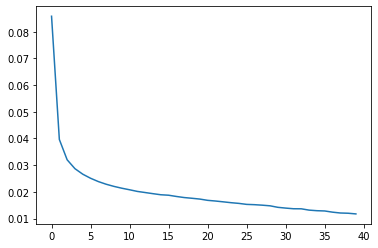

In [ ]:
plt.plot(train_loss)

In [15]:
for name, param in bigru.named_parameters():
    if param.requires_grad:
        print(param)

Parameter containing:
tensor([[ 0.0499, -0.0784, -0.0541,  ..., -0.0392, -0.0513, -0.0218],
        [-0.1121, -0.0255, -0.0955,  ..., -0.0885,  0.0053,  0.0589],
        [-0.0219,  0.0817,  0.0202,  ...,  0.0136,  0.0225,  0.0272],
        ...,
        [-0.0107, -0.0149, -0.0518,  ...,  0.0258, -0.0438,  0.0099],
        [ 0.0459,  0.0095,  0.0585,  ...,  0.0237, -0.0248, -0.0753],
        [ 0.0235, -0.0744,  0.0337,  ...,  0.0134, -0.0179,  0.0554]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0328, -0.0427,  0.0671,  ..., -0.0641,  0.0616,  0.0218],
        [ 0.0387,  0.0280, -0.0442,  ...,  0.0384, -0.1549,  0.0868],
        [ 0.0095, -0.0153,  0.0220,  ...,  0.0215,  0.0454, -0.0646],
        ...,
        [-0.0073, -0.0781, -0.0634,  ..., -0.0203, -0.0702, -0.0383],
        [ 0.0646, -0.0573, -0.0036,  ...,  0.0759,  0.0689,  0.0434],
        [-0.0192,  0.0176,  0.0133,  ..., -0.0329,  0.0698,  0.1183]],
       device='cuda:0', requires_grad=True)


In [ ]:
reverse_gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True, bidirectional=True).to(device)
reverse_gru.weight_ih_l0 = bigru.bi_gru.weight_ih_l0_reverse
reverse_gru.weight_hh_l0 = bigru.bi_gru.weight_hh_l0_reverse
reverse_gru.bias_ih_l0 = bigru.bi_gru.bias_ih_l0_reverse
reverse_gru.bias_hh_l0 = bigru.bi_gru.bias_hh_l0_reverse

reverse_gru.weight_ih_l0_reverse = bigru.bi_gru.weight_ih_l0
reverse_gru.weight_hh_l0_reverse = bigru.bi_gru.weight_hh_l0
reverse_gru.bias_ih_l0_reverse = bigru.bi_gru.bias_ih_l0
reverse_gru.bias_hh_l0_reverse = bigru.bi_gru.bias_hh_l0

activation = nn.Tanh()
 
def testing(model, reverse_model, test_loader, scaler):
    model.eval()
    reverse_model.eval()
    
    for first, mid, last in test_loader:
        size = first.size(0)
        first = first.float().to(device)
        mid = mid.float().to(device)
        last = last.float().to(device)

        forward = torch.zeros((size, frames, input_size))
        forward[:, 0] = first.squeeze(1)
        out = first
        h = init_state(size, model.num_layer, model.hidden_size)
        for t in range(1, frames):
            out, h = model.bi_gru(out, h)  
            out = model.fc(out)
            out = activation(out)
            forward[:, t] = out.squeeze(1)
  
        backward = torch.zeros((size, frames, input_size))
        backward[:, -1] = last.squeeze(1)
        out = last
        h = init_state(size, model.num_layer, model.hidden_size)
        for t in reversed(range(0, frames-1)):
            temp, h = reverse_model(out, h)
            out = torch.zeros(temp.size()).to(device)
            out[:, :, :hidden_size] = temp[: ,:, -hidden_size:]
            out[:, :, -hidden_size:] = temp[: ,:, :hidden_size]
            out = model.fc(out)
            out = activation(out)         
            backward[:, t] = out.squeeze(1)

    reconstruct = torch.zeros((size, frames, input_size)).to(device)
    for i in range(size):
        diff = torch.zeros(frames)
        for f_id in range(frames):
            loss = nn.MSELoss()
            diff[f_id] = loss(forward[i][f_id], backward[i][f_id])
        idx = torch.argmin(diff)
        # print(diff)
        print(idx)
        
        reconstruct[i][:idx] = forward[i][:idx]
        reconstruct[i][-idx:] = backward[i][-idx:]

        reconstruct[i][0] = first[i]
        reconstruct[i][-1] = last[i]
        print(loss(reconstruct[i][1:-1], mid[i]))

    rec_jacob = reconstruct.reshape((size, frames, -1))[:, :, :40].reshape((size, -1))
    rec_jacob = scaler.inverse_transform(rec_jacob.cpu().detach().numpy()).reshape((size, frames, 10, 2, 2))
    rec_value = reconstruct.reshape((size, frames, -1))[:, :, 40:].reshape((size, frames, 10, 2))

    return torch.tensor(rec_jacob).to(device), rec_value
    

In [ ]:
rec_jacob, rec_value = testing(bigru, reverse_gru, test_loader, scaler)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:740: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


tensor(8)
tensor(0.0522, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(8)
tensor(0.0527, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(7)
tensor(0.0652, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(8)
tensor(0.0463, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(8)
tensor(0.0512, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(7)
tensor(0.0601, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(8)
tensor(0.0521, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(8)
tensor(0.0544, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(8)
tensor(0.0469, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(7)
tensor(0.0616, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(7)
tensor(0.0661, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(8)
tensor(0.0491, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(8)
tensor(0.0540, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(8)
tensor(0.0469, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(8)
tensor(0.0483, device='c

In [ ]:
torch.max(rec_value)

tensor(0.6184, device='cuda:0', grad_fn=<MaxBackward1>)

In [ ]:
torch.min(rec_value)

tensor(-0.9309, device='cuda:0', grad_fn=<MinBackward1>)

In [ ]:
torch.min(rec_jacob)

tensor(-7.3608, device='cuda:0')

In [ ]:
rec_jacob.shape

torch.Size([109, 16, 10, 2, 2])

In [ ]:
rec_jacob = rec_jacob.cpu().detach().numpy()
rec_value = rec_value.cpu().detach().numpy()

In [ ]:
np.save("rec_jacobian", rec_jacob)

In [ ]:
np.save("rec_value", rec_value)